In [1]:
import utils
import matlab.engine
import dataset
import lstm_model

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=64,
    num_subcarriers=160,
    train_test_split=0.8,
    data_root="../data/dataset1",
    # duplicate_data=1,
    # data_snr=-1
)

train_set, test_set = dataset.load_data(cfg)
matlab = matlab.engine.start_matlab()
refModel = lstm_model.FullLSTMModel(cfg, matlab)

This is the LSTM


In [2]:
refModel.fit(train_set)

Fitting the PCA
Reducing offloading overhead...
Fitting the LSTM
Epoch 1/30


/Users/dziper/opt/anaconda3/envs/csi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0831
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0564
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0472
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0440
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0389
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0362
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0369
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0330
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0321
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0308
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0301
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279
Epoch 13/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0270
Epoch 14/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0287
Epoch 15/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0265


  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:
# Downlink
compressed_error, X_test = refModel.process(test_set)

# Uplink
predicted_csis, ul_pred_zdl = refModel.decode(compressed_error, X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Assessing performance...
Plotting results...


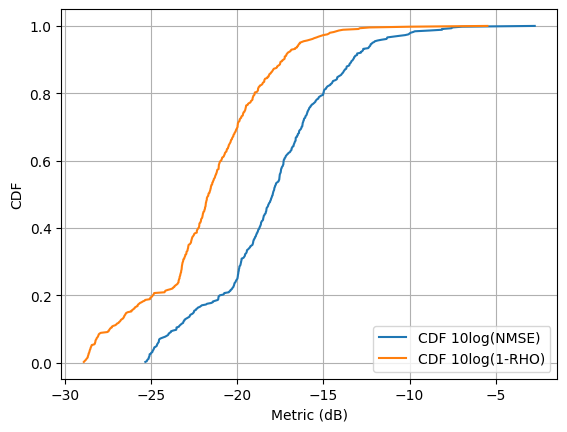

In [4]:
utils.reference_nmse_rho_test(test_set.csi_samples[cfg.predictor_window_size:], predicted_csis)